(2.3)=
## 2.3 Data Exploration Report

In this section, we will explore the data and present our findings:

* Statistics: basic descriptive statistics for each feature (mean, median, range, standard deviation, etc.).
* Visualizations: charts or graphs that help understand the data better. These might include histograms, scatter plots, box plots, etc.
* Initial findings: any interesting insights gained from the data, potential relationships between features, or patterns in the data.
* Potential hypotheses: based on our initial exploration, propose hypotheses about the data that could be tested or investigated further in the data mining process.

(2.3.1)=
### 2.3.1 File access and save paths
Here we will import the helper functions and setup up the save paths for the data and figures that are generated.

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [17]:
# create the file paths for reading in data and for outputting figures and tables
DATA_PATH = "../data/saville_row_east_west/"
OUTPUT_TABLES_PATH = "../output/tables/2.3/"
OUTPUT_FIGURES_PATH = "../output/figures/2.3/"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(OUTPUT_TABLES_PATH, exist_ok=True)
os.makedirs(OUTPUT_FIGURES_PATH, exist_ok=True)

# get custom color palette and colormap
from eda_helper import get_custom_palette, get_custom_colormap

custom_palette = get_custom_palette()
custom_colormap = get_custom_colormap()

# read in the files for exploration
east_df = pd.read_pickle(os.path.join(DATA_PATH, "east_df.pkl"))
west_df = pd.read_pickle(os.path.join(DATA_PATH, "west_df.pkl"))

If we look at some of the descriptive statistics we can see that the data sets are both fairly similar. We will focus on the `value` attribute which show the number of people detected in the last 15-minutes. From the stats we can see that the east facing sensor is slightly more skewed towards zero than the west facing sensor. 

In [18]:
east_ped_counts_descriptive = east_df["value"].describe().round(1)
west_ped_counts_descriptive = west_df["value"].describe().round(1)
print("East - Value")
display(pd.DataFrame(east_ped_counts_descriptive))
print("West - Value")
display(pd.DataFrame(west_ped_counts_descriptive))

East - Value


,value
count,79522.0
mean,76.9
std,102.3
min,0.0
25%,7.0
50%,30.0
75%,112.0
max,1898.0


West - Value


,value
count,79787.0
mean,99.9
std,136.3
min,0.0
25%,7.0
50%,40.0
75%,141.0
max,2432.0


In [19]:
east_ped_counts_descriptive.to_csv(
    os.path.join(
        OUTPUT_TABLES_PATH,
        "East sensor descriptive statistics for pedestrian count.csv",
    )
)
west_ped_counts_descriptive.to_csv(
    os.path.join(
        OUTPUT_TABLES_PATH,
        "West sensor descriptive statistics for pedestrian count.csv",
    )
)

In [20]:
# sorts east_df by hour and minute of the day
east_df = east_df.sort_values("time")

# groups on year-month-day-hour and yields sum (total pedestrians per hour)
east_hour_of_the_day_sum_df = (
    east_df.groupby("year-month-day-hour")
    .agg(
        {
            "value": "sum",
            "hours_since_midnight": "first",
            "time": "first",
            "year-month": "first",
            "month": "first",
            "month-hour": "first",
        }
    )
    .sort_values("hours_since_midnight")
    .reset_index()
)

# groups and sums on month-hour and yield mean (average pedestrians per hour in each month)
east_hour_month_average_df = (
    east_hour_of_the_day_sum_df.groupby("month-hour")
    .agg({"value": "mean", "hours_since_midnight": "first", "month": "first"})
    .sort_values("hours_since_midnight")
    .reset_index()
)

# sorts west_df by hour and minute of the day
west_df = west_df.sort_values("time")

# groups on year-month-day-hour and yields sum (total pedestrians per hour)
west_hour_of_the_day_sum_df = (
    west_df.groupby("year-month-day-hour")
    .agg(
        {
            "value": "sum",
            "hours_since_midnight": "first",
            "time": "first",
            "year-month": "first",
            "month": "first",
            "month-hour": "first",
        }
    )
    .sort_values("hours_since_midnight")
    .reset_index()
)

# groups and sums on month-hour and yield mean (average pedestrians per hour in each month)
west_hour_month_average_df = (
    west_hour_of_the_day_sum_df.groupby("month-hour")
    .agg({"value": "mean", "hours_since_midnight": "first", "month": "first"})
    .sort_values("hours_since_midnight")
    .reset_index()
)

(2.3.2)=
### 2.3.2 Overview of Flow Patterns

(2.3.2.1)=
#### 2.3.2.1 Average flow per hour by month
The following graph shows the variation in average flow for each month at each hour of the day. We can see that there is a large difference in flow between the east and west sensor, this suggests that the west side the street is generally busier than the east side (~ 30% more usage throughout the year). This could be due to the utility of the retail on the west side of the street. 

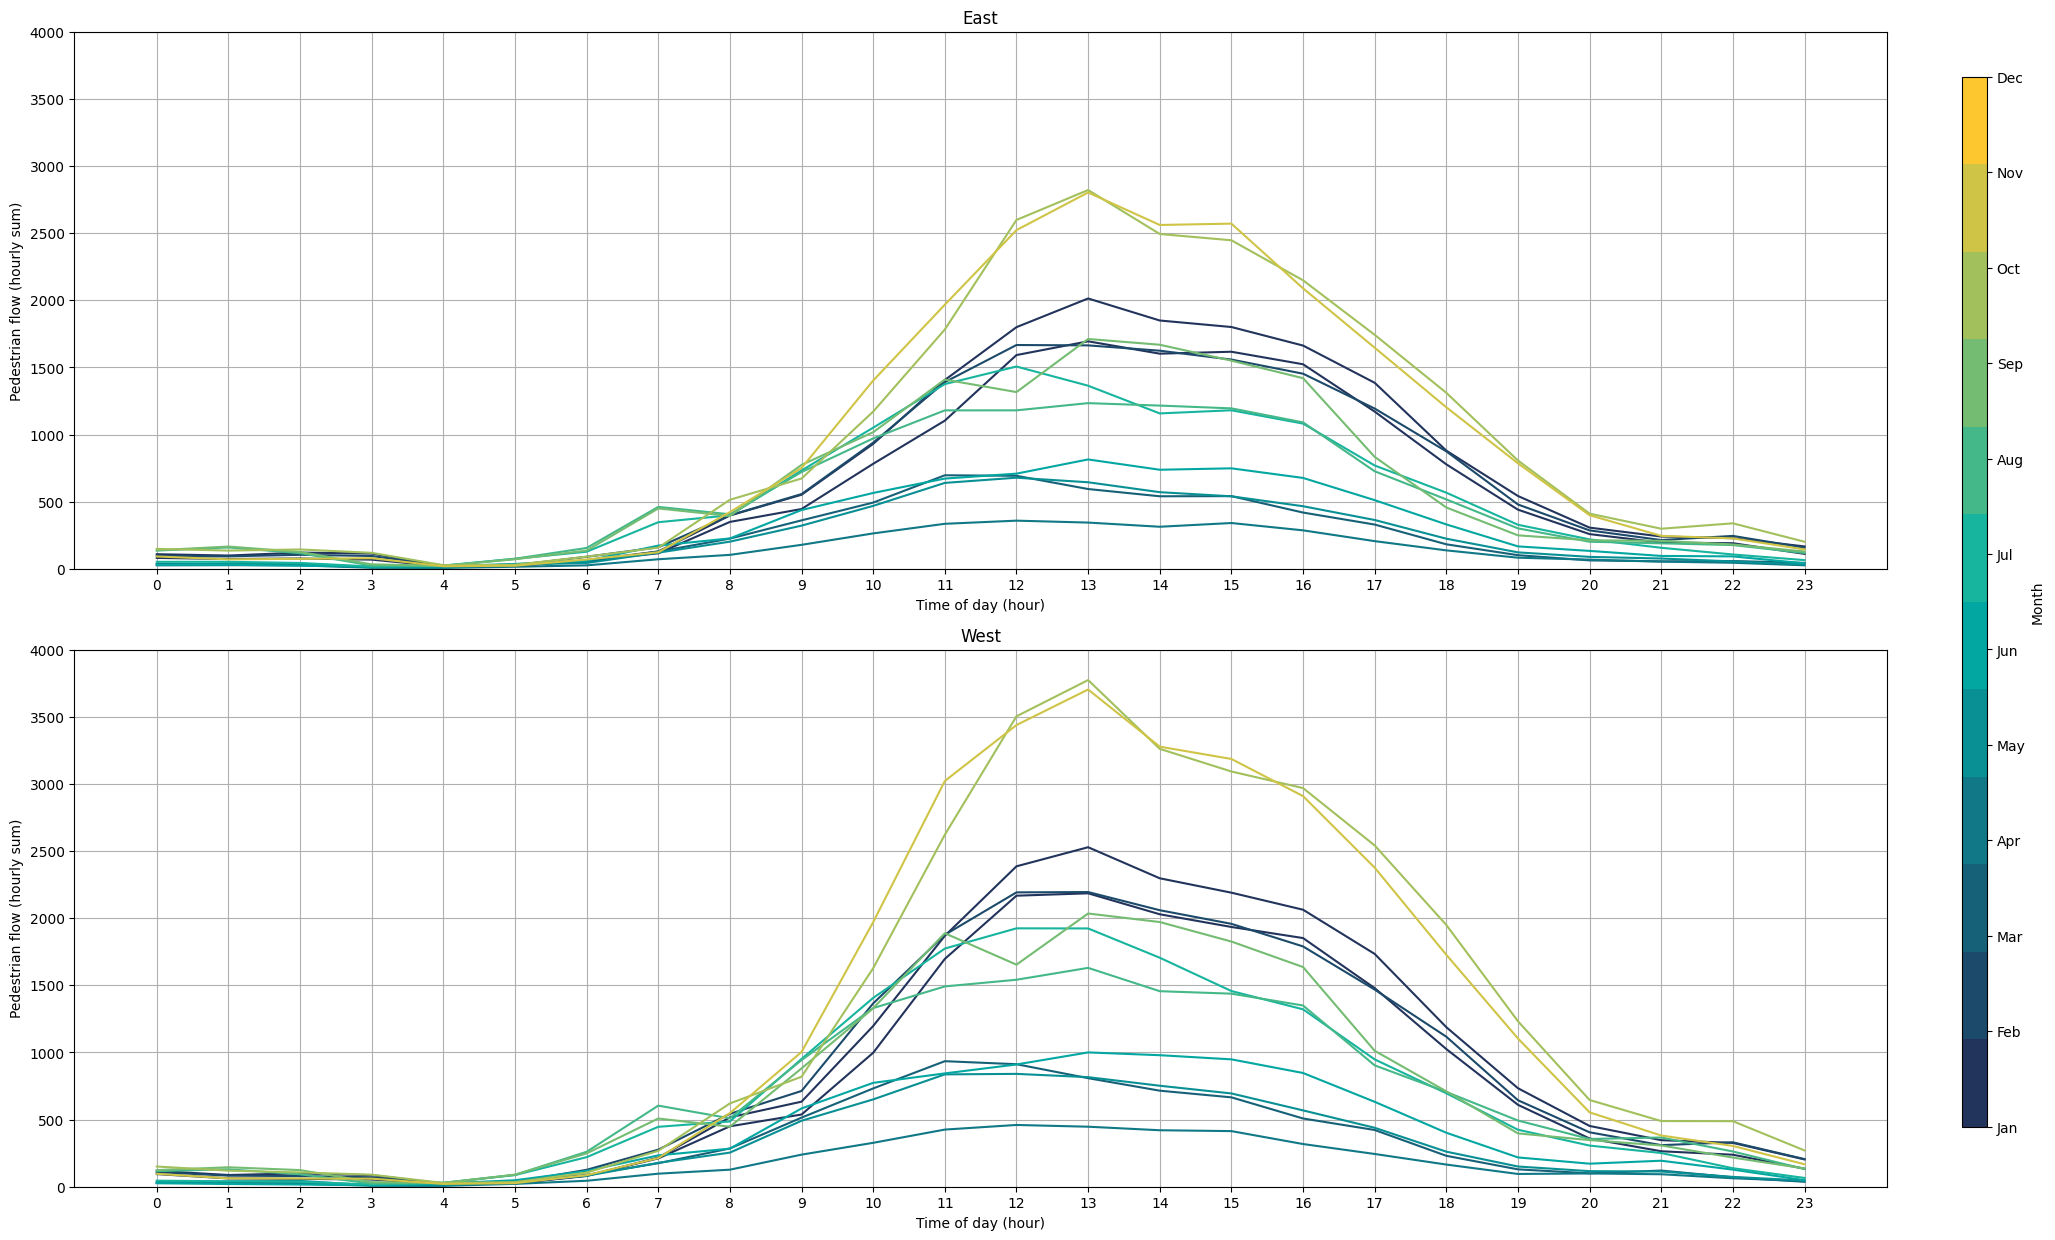

In [21]:
import matplotlib

east_len_months = len(set(east_hour_month_average_df["month"]))
cmap = matplotlib.colors.ListedColormap(
    [custom_colormap(i / (east_len_months - 1)) for i in range(east_len_months)]
)

fig, ax = plt.subplots(2, 1, figsize=(25, 15), gridspec_kw={"hspace": 0.15})

# loop through each unique month value for east
for i, month in enumerate(set(east_hour_month_average_df["month"])):
    # filter the DataFrame for the current month
    month_df = east_hour_month_average_df[east_hour_month_average_df["month"] == month]

    # plot the line for the current month with the corresponding color from the colormap
    ax[0].plot(
        month_df["hours_since_midnight"].astype(str),
        month_df["value"],
        color=cmap(i - 1),
        label=f"Month {month}",
    )

ax[0].set_xlabel("Time of day (hour)")
ax[0].set_ylabel("Pedestrian flow (hourly sum)")
ax[0].set_title("East")
ax[0].set_ylim(0, 4000)
ax[0].grid(True)

# loop through each unique month value for west
for i, month in enumerate(set(west_hour_month_average_df["month"])):
    # filter the DataFrame for the current month
    month_df = west_hour_month_average_df[west_hour_month_average_df["month"] == month]

    # plot the line for the current month with the corresponding color from the colormap
    ax[1].plot(
        month_df["hours_since_midnight"].astype(str),
        month_df["value"],
        color=cmap(i - 1),
        label=f"Month {month}",
    )

ax[1].set_xlabel("Time of day (hour)")
ax[1].set_ylabel("Pedestrian flow (hourly sum)")
ax[1].set_title("West")
ax[1].set_ylim(0, 4000)
ax[1].grid(True)

fig.subplots_adjust(right=0.85)  # create some space on the right side for the colorbar

cbar_ax = fig.add_axes(
    [0.88, 0.15, 0.01, 0.7]
)  # position of colorbar [left, bottom, width, height]

# add a colorbar to show the mapping of colors to months
norm = matplotlib.colors.Normalize(vmin=1, vmax=east_len_months)
cbar = fig.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax,
    ticks=np.arange(1, east_len_months + 1),
)

cbar.ax.set_yticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
cbar.set_label("Month")

plt.savefig(
    os.path.join(OUTPUT_FIGURES_PATH, "Average flow per hour by month.svg"),
    bbox_inches="tight",
)
plt.show()

```{figure} graphics\east_and_west_sensors.png
:name: east-west-sensors

East and west facing sensors on northumberland street
```

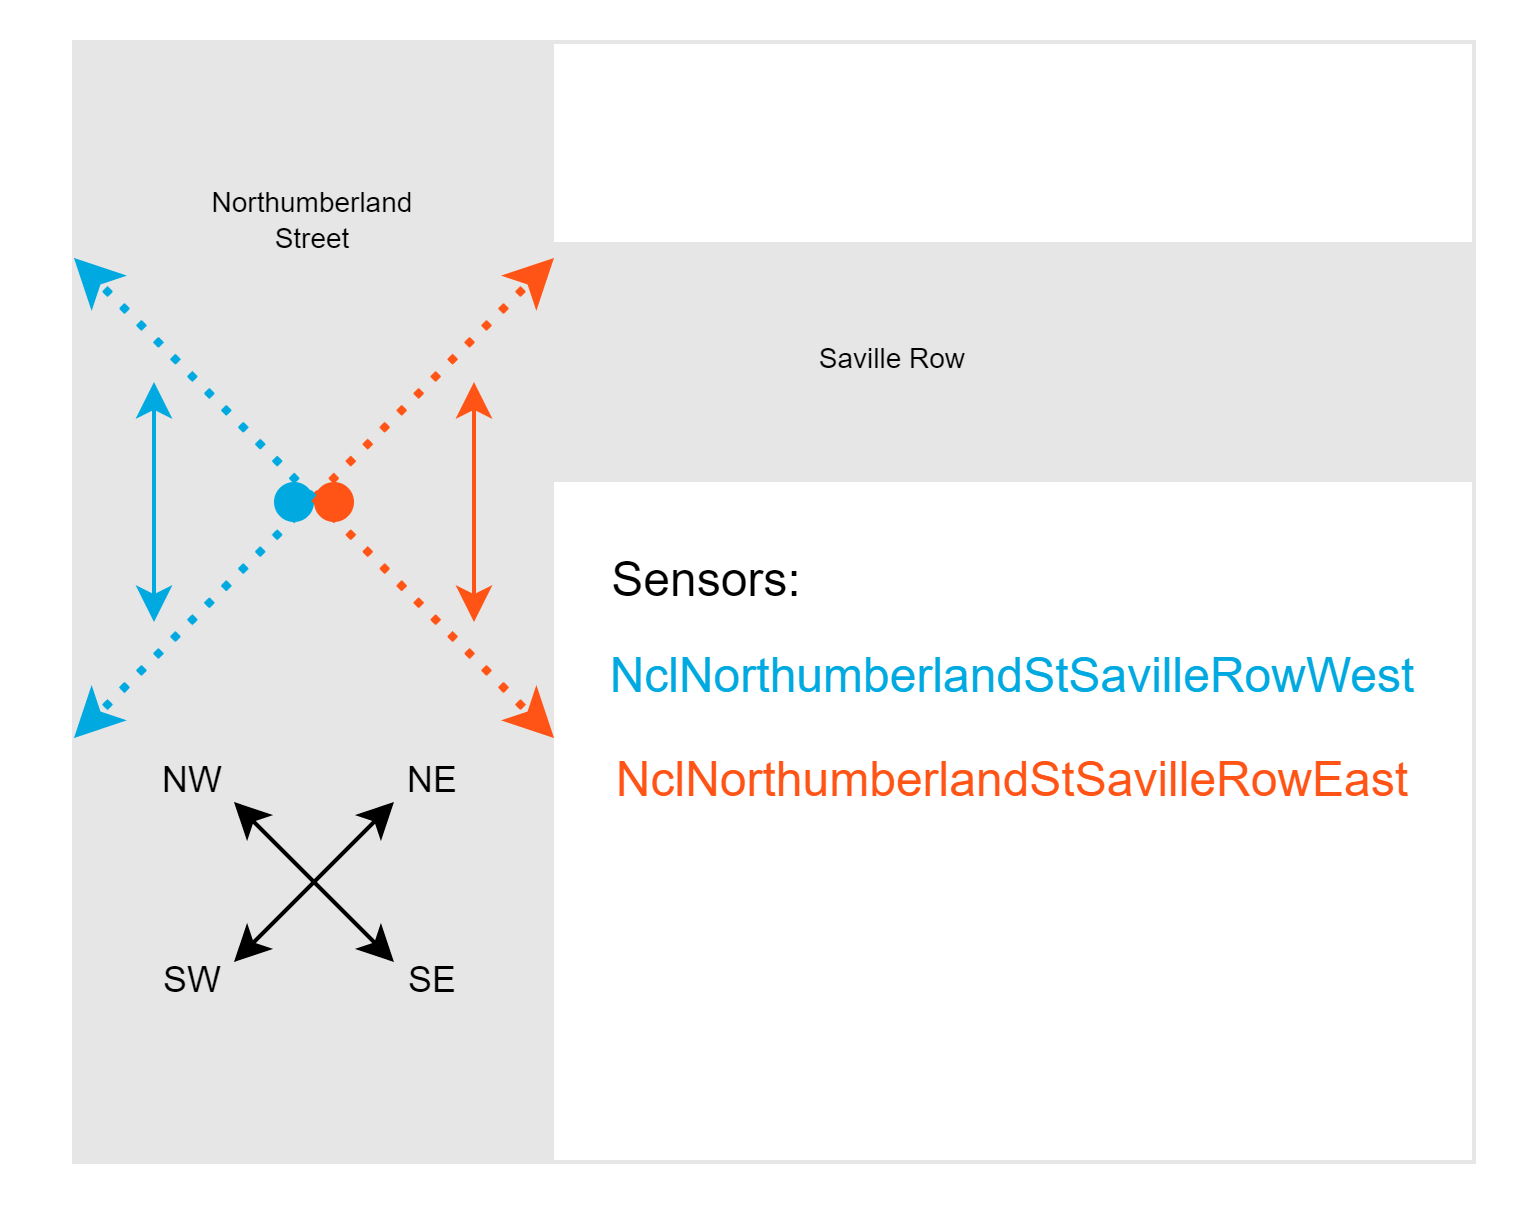

In [22]:
from IPython import display
import os

display.Image(
    os.path.join(os.getcwd(), "graphics\east_and_west_sensors.png"),
    width=768,
    height=768,
)

(2.3.2.2)=
#### 2.3.2.2 Flow per hour by month and quarter with mean trendline
The following graph shows the variation in flow throughout the day and across each month and each quarter over a 15 minute period this time. A couple of things are of note here. The first is that there appears to be a a significant difference in the average flow for different months with December and November experiencing far greater flow than in May and June. The y-axis has been limited to 1000, but outliers exist up to 1750 pedestrians per 15 minute period (see section 2.4).It is also worth noting that by grouping into quarters the general pattern shown in the monthly grouping is retained. 

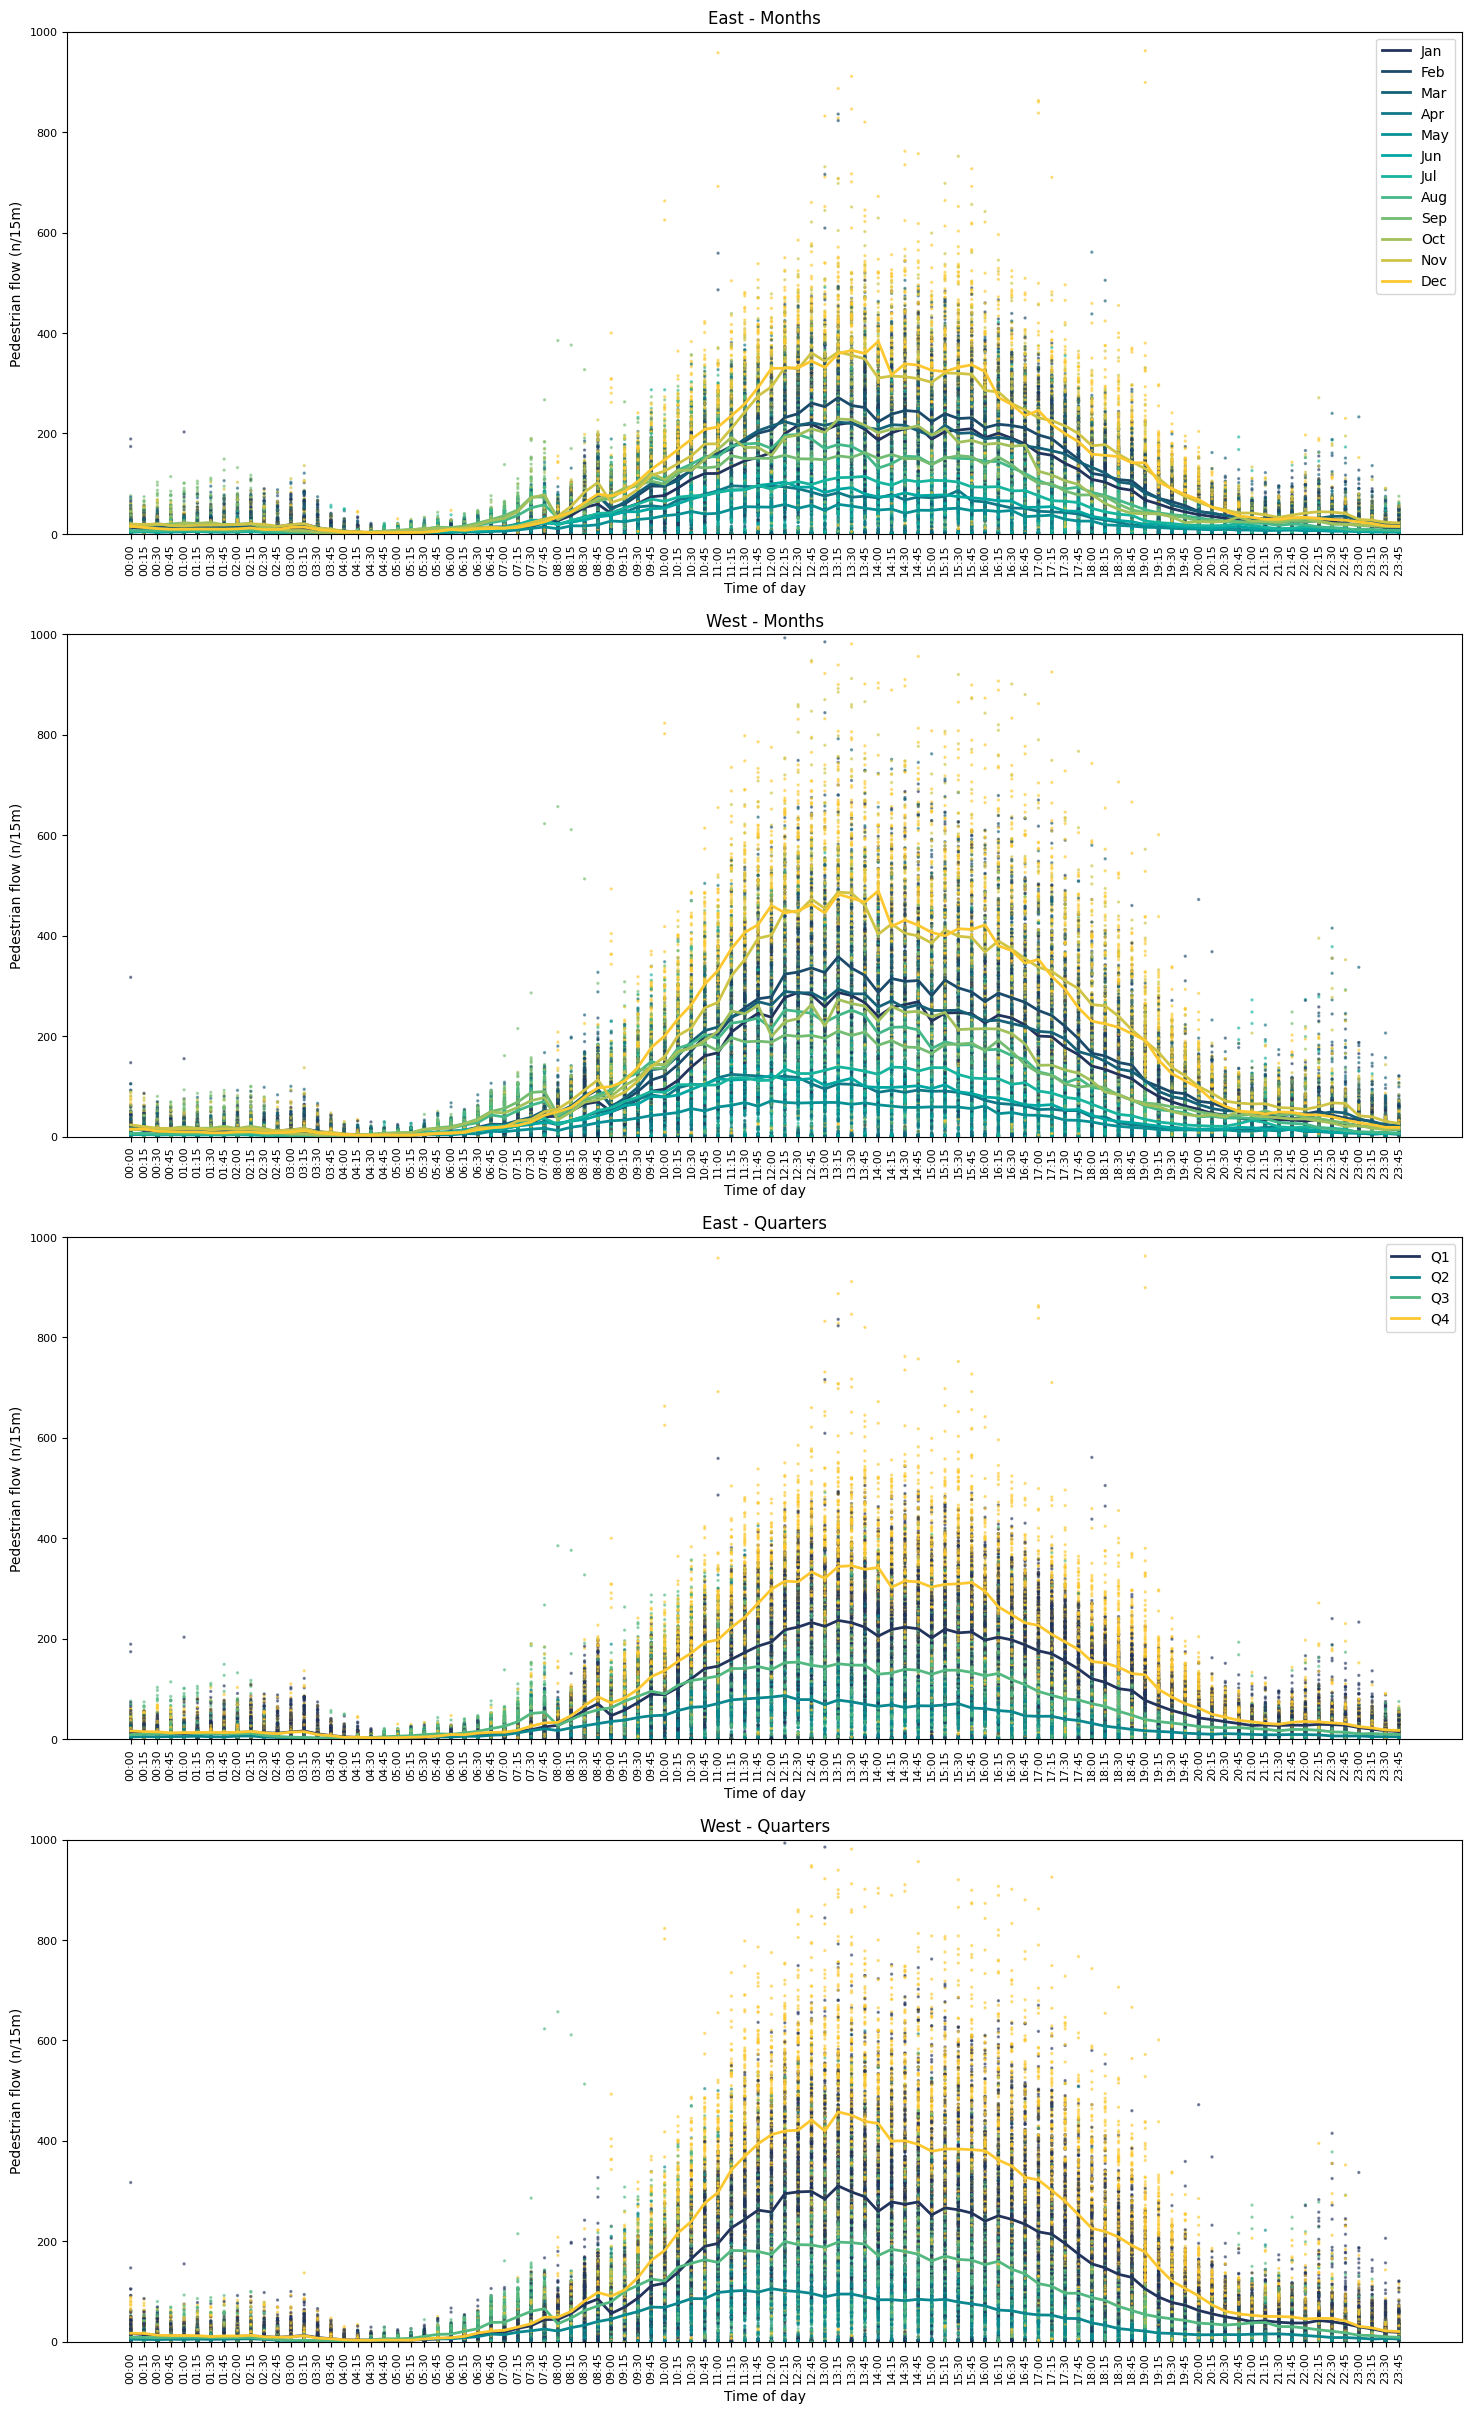

In [23]:
############### Months

# instantiate the color map and reverse it so it matches the legend order
cmap = matplotlib.colors.ListedColormap([custom_colormap(i / 11) for i in range(12)])

# For East
east_monthly_interval_mean_df = (
    east_df.groupby(["month", "hour-minutes"])["value"].mean().reset_index()
)

# For West
west_monthly_interval_mean_df = (
    west_df.groupby(["month", "hour-minutes"])["value"].mean().reset_index()
)

fig, ax = plt.subplots(4, 1, figsize=(18, 30))
fig.subplots_adjust(hspace=0.2)

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

for month in range(1, 13):
    # For East
    month_data = east_monthly_interval_mean_df[
        east_monthly_interval_mean_df["month"] == month
    ]
    ax[0].plot(
        month_data["hour-minutes"].astype(str),
        month_data["value"],
        linewidth=2,
        label=f"{month_names[month - 1]}",
        color=cmap.colors[month - 1],
    )
    # For West
    month_data = west_monthly_interval_mean_df[
        west_monthly_interval_mean_df["month"] == month
    ]
    ax[1].plot(
        month_data["hour-minutes"].astype(str),
        month_data["value"],
        linewidth=2,
        label=f"{month_names[month - 1]}",
        color=cmap.colors[month - 1],
    )

ax[0].legend()

sc = ax[0].scatter(
    x=east_df["hour-minutes"].astype(str),
    y=east_df["value"],
    c=east_df["month"],
    cmap=cmap,
    alpha=0.5,
    s=2,
)
sc = ax[1].scatter(
    x=west_df["hour-minutes"].astype(str),
    y=west_df["value"],
    c=west_df["month"],
    cmap=cmap,
    alpha=0.5,
    s=2,
)

ax[0].tick_params(axis="x", rotation=90)
ax[0].set_xlabel("Time of day")
ax[0].set_ylabel("Pedestrian flow (n/15m)")
ax[0].tick_params(labelsize=8)
ax[0].set_ylim(0, 1000)
ax[0].set_title("East - Months")
ax[1].tick_params(axis="x", rotation=90)
ax[1].set_xlabel("Time of day")
ax[1].set_ylabel("Pedestrian flow (n/15m)")
ax[1].tick_params(labelsize=8)
ax[1].set_title("West - Months")
ax[1].set_ylim(0, 1000)

############### Quarters

# instantiate the color map and reverse it so it matches the legend order
cmap = matplotlib.colors.ListedColormap([custom_colormap(i / 3) for i in range(4)])

# For East
east_quarter_interval_mean_df = (
    east_df.groupby(["quarter", "hour-minutes"])["value"].mean().reset_index()
)
# For West
west_quarter_interval_mean_df = (
    west_df.groupby(["quarter", "hour-minutes"])["value"].mean().reset_index()
)

sc = ax[2].scatter(
    x=east_df["hour-minutes"].astype(str),
    y=east_df["value"],
    c=east_df["quarter"],
    cmap=cmap,
    alpha=0.5,
    s=2,
)
sc = ax[3].scatter(
    x=west_df["hour-minutes"].astype(str),
    y=west_df["value"],
    c=west_df["quarter"],
    cmap=cmap,
    alpha=0.5,
    s=2,
)

for quarter in range(1, 5):
    # For East
    quarter_data = east_quarter_interval_mean_df[
        east_quarter_interval_mean_df["quarter"] == quarter
    ]
    ax[2].plot(
        quarter_data["hour-minutes"].astype(str),
        quarter_data["value"],
        linewidth=2,
        label=f"Q{quarter}",
        color=cmap.colors[quarter - 1],
    )
    # For West
    quarter_data = west_quarter_interval_mean_df[
        west_quarter_interval_mean_df["quarter"] == quarter
    ]
    ax[3].plot(
        quarter_data["hour-minutes"].astype(str),
        quarter_data["value"],
        linewidth=2,
        label=f"Q{quarter}",
        color=cmap.colors[quarter - 1],
    )

ax[2].legend()

ax[2].tick_params(axis="x", rotation=90)
ax[2].set_xlabel("Time of day")
ax[2].set_ylabel("Pedestrian flow (n/15m)")
ax[2].tick_params(labelsize=8)
ax[2].set_title("East - Quarters")
ax[2].set_ylim(0, 1000)
ax[3].tick_params(axis="x", rotation=90)
ax[3].set_xlabel("Time of day")
ax[3].set_ylabel("Pedestrian flow (n/15m)")
ax[3].tick_params(labelsize=8)
ax[3].set_title("West - Quarters")
ax[3].set_ylim(0, 1000)
################ Save both figs

plt.savefig(
    os.path.join(OUTPUT_FIGURES_PATH, "East_and_West_total_Flow_per_15_Min_Period.svg"),
    bbox_inches="tight",
)
plt.show()

(2.3.2.3)=
#### 2.3.2.3 Weekday vs Weekend flow per hour by quarter with mean trendline
The following graph shows the mean variation in flow throughout the day and across each quarter for weekdays and weekend. From visual inspection it is clear that there is a variation in the shape of the trendline when comparing the same quarter in both graphs for weekday vs weekend. 

In [24]:
# create a mask for weekdays (monday-friday)
weekday_mask = east_df["dt"].dt.weekday < 5

# create seperate dataframes for weekdays and weekends
weekday_east_df = east_df[weekday_mask]
weekend_east_df = east_df[-weekday_mask]

# create a mask for weekdays (monday-friday)
weekday_mask = west_df["dt"].dt.weekday < 5

# create seperate dataframes for weekdays and weekends
weekday_west_df = west_df[weekday_mask]
weekend_west_df = west_df[-weekday_mask]

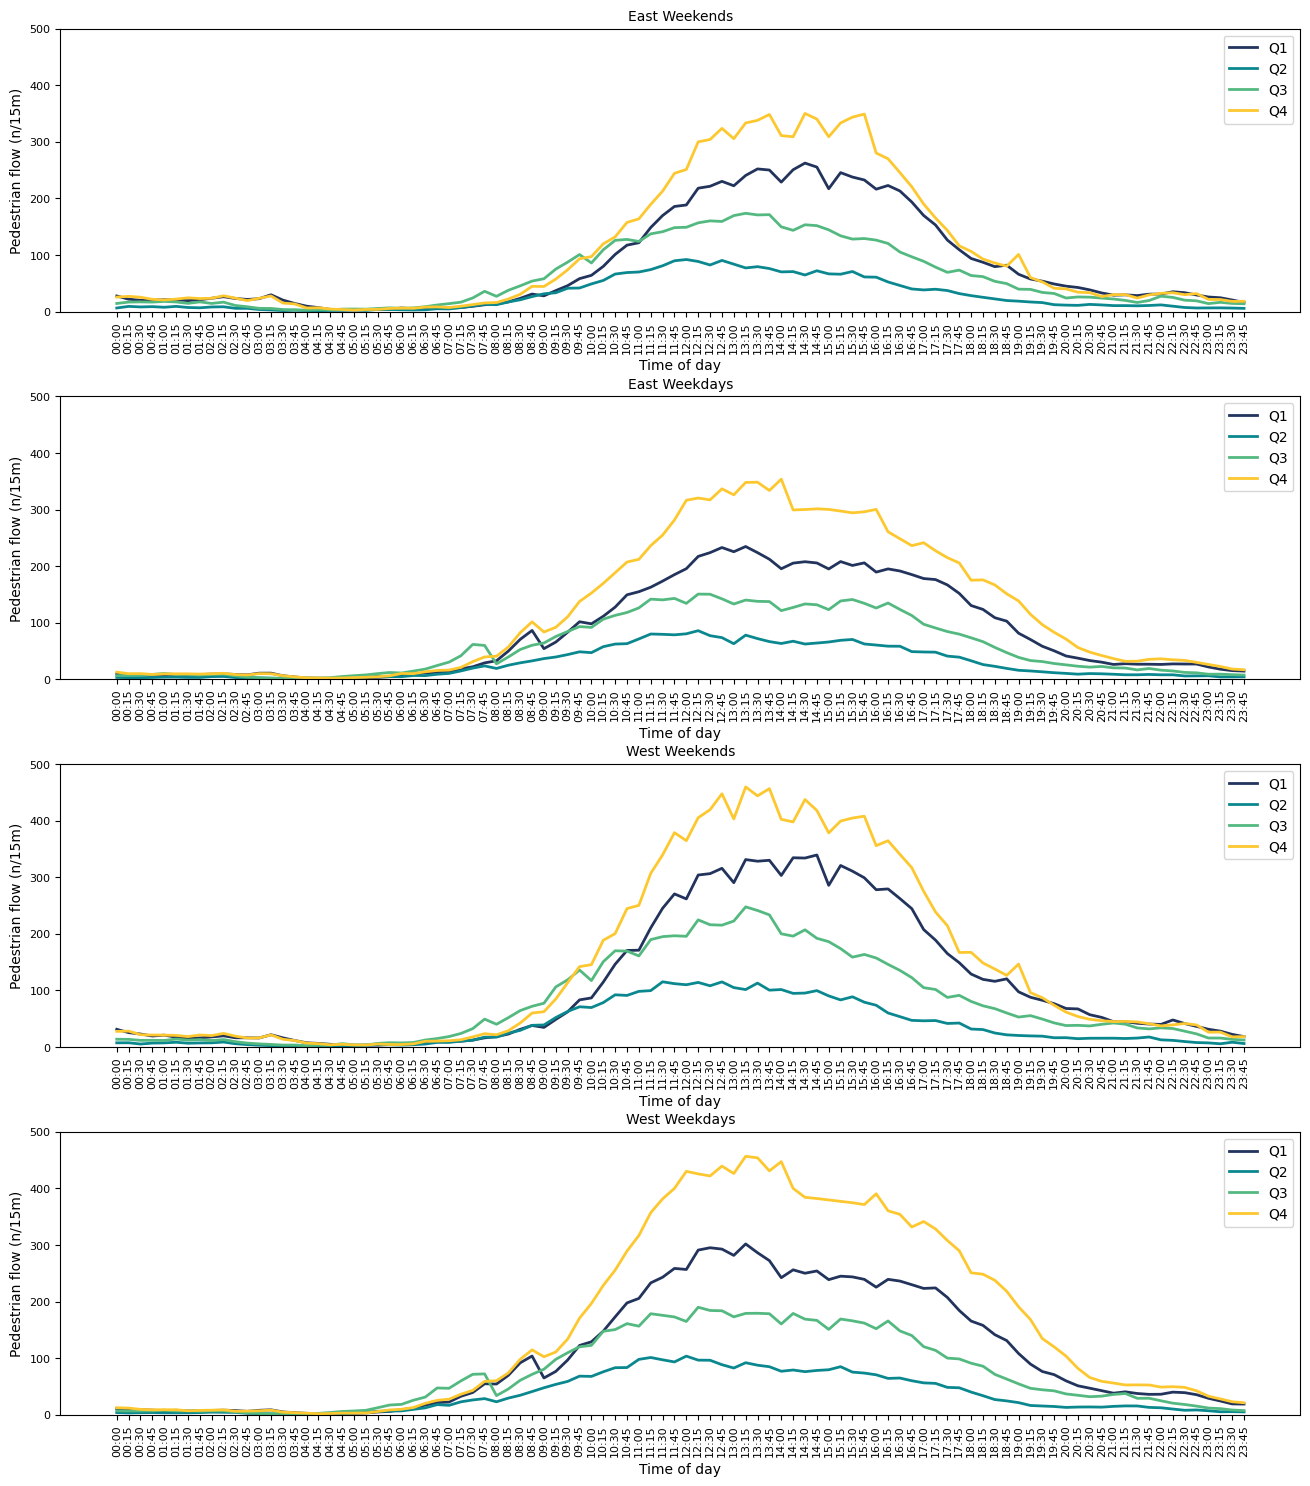

In [25]:
# instantiate the color map and reverse it so it matches the legend order
cmap = matplotlib.colors.ListedColormap([custom_colormap(i / 3) for i in range(4)])

fig, ax = plt.subplots(4, 1, figsize=(16, 18))
fig.subplots_adjust(hspace=0.3)

# For East Weekends
east_quarter_interval_mean_df = (
    weekend_east_df.groupby(["quarter", "hour-minutes"])["value"].mean().reset_index()
)
# For West Weekends
west_quarter_interval_mean_df = (
    weekend_west_df.groupby(["quarter", "hour-minutes"])["value"].mean().reset_index()
)


for quarter in range(1, 5):
    # For East
    quarter_data = east_quarter_interval_mean_df[
        east_quarter_interval_mean_df["quarter"] == quarter
    ]
    ax[0].plot(
        quarter_data["hour-minutes"].astype(str),
        quarter_data["value"],
        linewidth=2,
        label=f"Q{quarter}",
        color=cmap.colors[quarter - 1],
    )
    # For West
    quarter_data = west_quarter_interval_mean_df[
        west_quarter_interval_mean_df["quarter"] == quarter
    ]
    ax[2].plot(
        quarter_data["hour-minutes"].astype(str),
        quarter_data["value"],
        linewidth=2,
        label=f"Q{quarter}",
        color=cmap.colors[quarter - 1],
    )

ax[0].legend()
ax[2].legend()

ax[0].tick_params(axis="x", rotation=90)
ax[0].set_title("East Weekends", fontsize=10)
ax[0].set_xlabel("Time of day")
ax[0].set_ylabel("Pedestrian flow (n/15m)")
ax[0].set_ylim(0, 500)
ax[0].tick_params(labelsize=8)

ax[2].tick_params(axis="x", rotation=90)
ax[2].set_title("West Weekends", fontsize=10)
ax[2].set_xlabel("Time of day")
ax[2].set_ylabel("Pedestrian flow (n/15m)")
ax[2].set_ylim(0, 500)
ax[2].tick_params(labelsize=8)

# For East Weekdays
east_quarter_interval_mean_df = (
    weekday_east_df.groupby(["quarter", "hour-minutes"])["value"].mean().reset_index()
)
# For West Weekdays
west_quarter_interval_mean_df = (
    weekday_west_df.groupby(["quarter", "hour-minutes"])["value"].mean().reset_index()
)

for quarter in range(1, 5):
    # For East
    quarter_data = east_quarter_interval_mean_df[
        east_quarter_interval_mean_df["quarter"] == quarter
    ]
    ax[1].plot(
        quarter_data["hour-minutes"].astype(str),
        quarter_data["value"],
        linewidth=2,
        label=f"Q{quarter}",
        color=cmap.colors[quarter - 1],
    )
    # For West
    quarter_data = west_quarter_interval_mean_df[
        west_quarter_interval_mean_df["quarter"] == quarter
    ]
    ax[3].plot(
        quarter_data["hour-minutes"].astype(str),
        quarter_data["value"],
        linewidth=2,
        label=f"Q{quarter}",
        color=cmap.colors[quarter - 1],
    )

ax[1].legend()
ax[3].legend()

ax[1].tick_params(axis="x", rotation=90)
ax[1].set_title("East Weekdays", fontsize=10)
ax[1].set_xlabel("Time of day")
ax[1].set_ylabel("Pedestrian flow (n/15m)")
ax[1].set_ylim(0, 500)
ax[1].tick_params(labelsize=8)

ax[3].tick_params(axis="x", rotation=90)
ax[3].set_title("West Weekdays", fontsize=10)
ax[3].set_xlabel("Time of day")
ax[3].set_ylabel("Pedestrian flow (n/15m)")
ax[3].set_ylim(0, 500)
ax[3].tick_params(labelsize=8)

plt.savefig(
    os.path.join(
        OUTPUT_FIGURES_PATH,
        "Weekday_and_Weekend_Total_Flow_per_15_Min_Period_by_Quarter.svg",
    ),
    bbox_inches="tight",
)
plt.show()

(2.3.3)=
### 2.3.3 Properties of flow patterns

(2.3.3.1)=
#### 2.3.3.1 Pattern properties of quarterly mean trendlines

To investigate the differences between weekdays and weekends, we will generate some metrics that describe the properties of the mean curves and compare them. The metrics we will use are:
* Area Under Curve (AUC)
* Peak Time and Peak Value
* Width at Half Maximum (WHM)

In [26]:
from scipy import integrate

# initialize list to store metrics DataFrames for weekends and weekdays
east_weekend_metrics = []
east_weekday_metrics = []

east_quarter_interval_mean_df = (
    weekend_east_df.groupby(["quarter", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each quarter and add to DataFrame for weekends
for quarter in range(1, 5):
    quarter_data = east_quarter_interval_mean_df[
        east_quarter_interval_mean_df["quarter"] == quarter
    ]
    auc = integrate.trapz(
        quarter_data["value"], dx=15
    )  # dx time interval is 15 minutes
    peak_time = quarter_data["minutes_since_midnight"][quarter_data["value"].idxmax()]
    peak_value = quarter_data["value"].max()
    whm_time_range = quarter_data["minutes_since_midnight"][
        (quarter_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    east_weekend_metrics.append(
        pd.DataFrame(
            {
                "quarter": [f"Q{quarter}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# similarly, for weekdays
east_quarter_interval_mean_df = (
    weekday_east_df.groupby(["quarter", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each quarter and add to DataFrame for weekdays
for quarter in range(1, 5):
    quarter_data = east_quarter_interval_mean_df[
        east_quarter_interval_mean_df["quarter"] == quarter
    ]
    auc = integrate.trapz(
        quarter_data["value"], dx=15
    )  # dx time interval is 15 minutes
    peak_time = quarter_data["minutes_since_midnight"][quarter_data["value"].idxmax()]
    peak_value = quarter_data["value"].max()
    whm_time_range = quarter_data["minutes_since_midnight"][
        (quarter_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    east_weekday_metrics.append(
        pd.DataFrame(
            {
                "quarter": [f"Q{quarter}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# concatenate the list of dataframes to a single dataframe
east_weekend_metrics = pd.concat(east_weekend_metrics, ignore_index=True)
east_weekday_metrics = pd.concat(east_weekday_metrics, ignore_index=True)

print("East Weekend Metrics: ")
print(east_weekend_metrics)
print("East Weekday Metrics: ")
print(east_weekday_metrics)

East Weekend Metrics: 
  quarter            AUC  peak_time  peak_value  WHM
0      Q1  118374.531122        870  262.474227  360
1      Q2   42141.260671        720   92.023810  390
2      Q3   85991.696861        795  173.730769  450
3      Q4  150118.685195        870  350.230769  345
East Weekday Metrics: 
  quarter            AUC  peak_time  peak_value  WHM
0      Q1  119213.385863        795  234.697211  465
1      Q2   41661.795032        735   85.903846  465
2      Q3   83082.373054        735  150.603175  510
3      Q4  171294.785440        840  353.795455  435


In [27]:
weekend_west_df

,dt,value,veh_class,dir,location,category,key,date,time,hour-minutes,...,month-hour,year-month,year-week,hours_since_midnight,minutes_since_midnight,year-quarter,month,quarter,day_in_week,day_of_week
26885,2022-12-31 00:00:00,5,person,northwest_to_southwest,NclNorthumberlandStSavilleRowWest,flow,2022-12,2022-12-31,1900-01-01 00:00:00,00:00,...,12 00,2022-12,2022-52,0,0,2022-4,12,4,5,Saturday
26889,2022-12-31 00:00:00,16,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2022-12,2022-12-31,1900-01-01 00:00:00,00:00,...,12 00,2022-12,2022-52,0,0,2022-4,12,4,5,Saturday
5,2022-05-01 00:00:00,3,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2022-05,2022-05-01,1900-01-01 00:00:00,00:00,...,05 00,2022-05,2022-18,0,0,2022-2,5,2,6,Sunday
1,2022-05-01 00:00:00,1,person,northwest_to_southwest,NclNorthumberlandStSavilleRowWest,flow,2022-05,2022-05-01,1900-01-01 00:00:00,00:00,...,05 00,2022-05,2022-18,0,0,2022-2,5,2,6,Sunday
8469,2021-12-25 00:00:00,4,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2021-12,2021-12-25,1900-01-01 00:00:00,00:00,...,12 00,2021-12,2021-51,0,0,2021-4,12,4,5,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,2022-11-06 23:45:00,6,person,northwest_to_southwest,NclNorthumberlandStSavilleRowWest,flow,2022-11,2022-11-06,1900-01-01 23:45:00,23:45,...,11 23,2022-11,2022-45,23,1425,2022-4,11,4,6,Sunday
3280,2022-11-06 23:45:00,15,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2022-11,2022-11-06,1900-01-01 23:45:00,23:45,...,11 23,2022-11,2022-45,23,1425,2022-4,11,4,6,Sunday
3825,2022-01-09 23:45:00,2,person,southwest_to_northwest,NclNorthumberlandStSavilleRowWest,flow,2022-01,2022-01-09,1900-01-01 23:45:00,23:45,...,01 23,2022-01,2022-02,23,1425,2022-1,1,1,6,Sunday
3823,2022-01-09 23:45:00,3,person,northwest_to_southwest,NclNorthumberlandStSavilleRowWest,flow,2022-01,2022-01-09,1900-01-01 23:45:00,23:45,...,01 23,2022-01,2022-02,23,1425,2022-1,1,1,6,Sunday


In [28]:
# initialize list to store metrics DataFrames for weekends and weekdays
west_weekend_metrics = []
west_weekday_metrics = []

west_quarter_interval_mean_df = (
    weekend_west_df.groupby(["quarter", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each quarter and add to DataFrame for weekends
for quarter in range(1, 5):
    quarter_data = west_quarter_interval_mean_df[
        west_quarter_interval_mean_df["quarter"] == quarter
    ]
    auc = integrate.trapz(
        quarter_data["value"], dx=15
    )  # dx time interval is 15 minutes
    peak_time = quarter_data["minutes_since_midnight"][quarter_data["value"].idxmax()]
    peak_value = quarter_data["value"].max()
    whm_time_range = quarter_data["minutes_since_midnight"][
        (quarter_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    west_weekend_metrics.append(
        pd.DataFrame(
            {
                "quarter": [f"Q{quarter}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# similarly, for weekdays
west_quarter_interval_mean_df = (
    weekday_west_df.groupby(["quarter", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each quarter and add to DataFrame for weekdays
for quarter in range(1, 5):
    quarter_data = west_quarter_interval_mean_df[
        west_quarter_interval_mean_df["quarter"] == quarter
    ]
    auc = integrate.trapz(
        quarter_data["value"], dx=15
    )  # dx time interval is 15 minutes
    peak_time = quarter_data["minutes_since_midnight"][quarter_data["value"].idxmax()]
    peak_value = quarter_data["value"].max()
    whm_time_range = quarter_data["minutes_since_midnight"][
        (quarter_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    west_weekday_metrics.append(
        pd.DataFrame(
            {
                "quarter": [f"Q{quarter}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# concatenate the list of dataframes to a single dataframe
west_weekend_metrics = pd.concat(west_weekend_metrics, ignore_index=True)
west_weekday_metrics = pd.concat(west_weekday_metrics, ignore_index=True)

print("West Weekend Metrics: ")
print(west_weekend_metrics)
print("West Weekday Metrics: ")
print(west_weekday_metrics)

West Weekend Metrics: 
  quarter            AUC  peak_time  peak_value  WHM
0      Q1  156468.716432        885  339.402062  390
1      Q2   54892.356767        690  115.282609  405
2      Q3  113224.721871        795  247.700000  405
3      Q4  203720.461499        795  459.692308  390
West Weekday Metrics: 
  quarter            AUC  peak_time  peak_value  WHM
0      Q1  152382.089939        795  301.866397  465
1      Q2   51842.065547        720  103.590000  480
2      Q3  106045.781739        735  190.000000  510
3      Q4  230357.481070        795  456.709677  495


We can see that peak values remain fairly consistent between weekday/weekend but vary significantly throughout the quarter. The same pattern is very closely mirrored in the AUC curve. The peak time however, does not vary massively throughout the year and there is greater variation between weekends and weekdays. This pattern is reflected more strongly in the WHM plot, where we can see that the weekday/weekend variation is significantly greater than the inter-quarter variation. We can see that these patterns are mirrored and slightly offset for both the sensors directions.

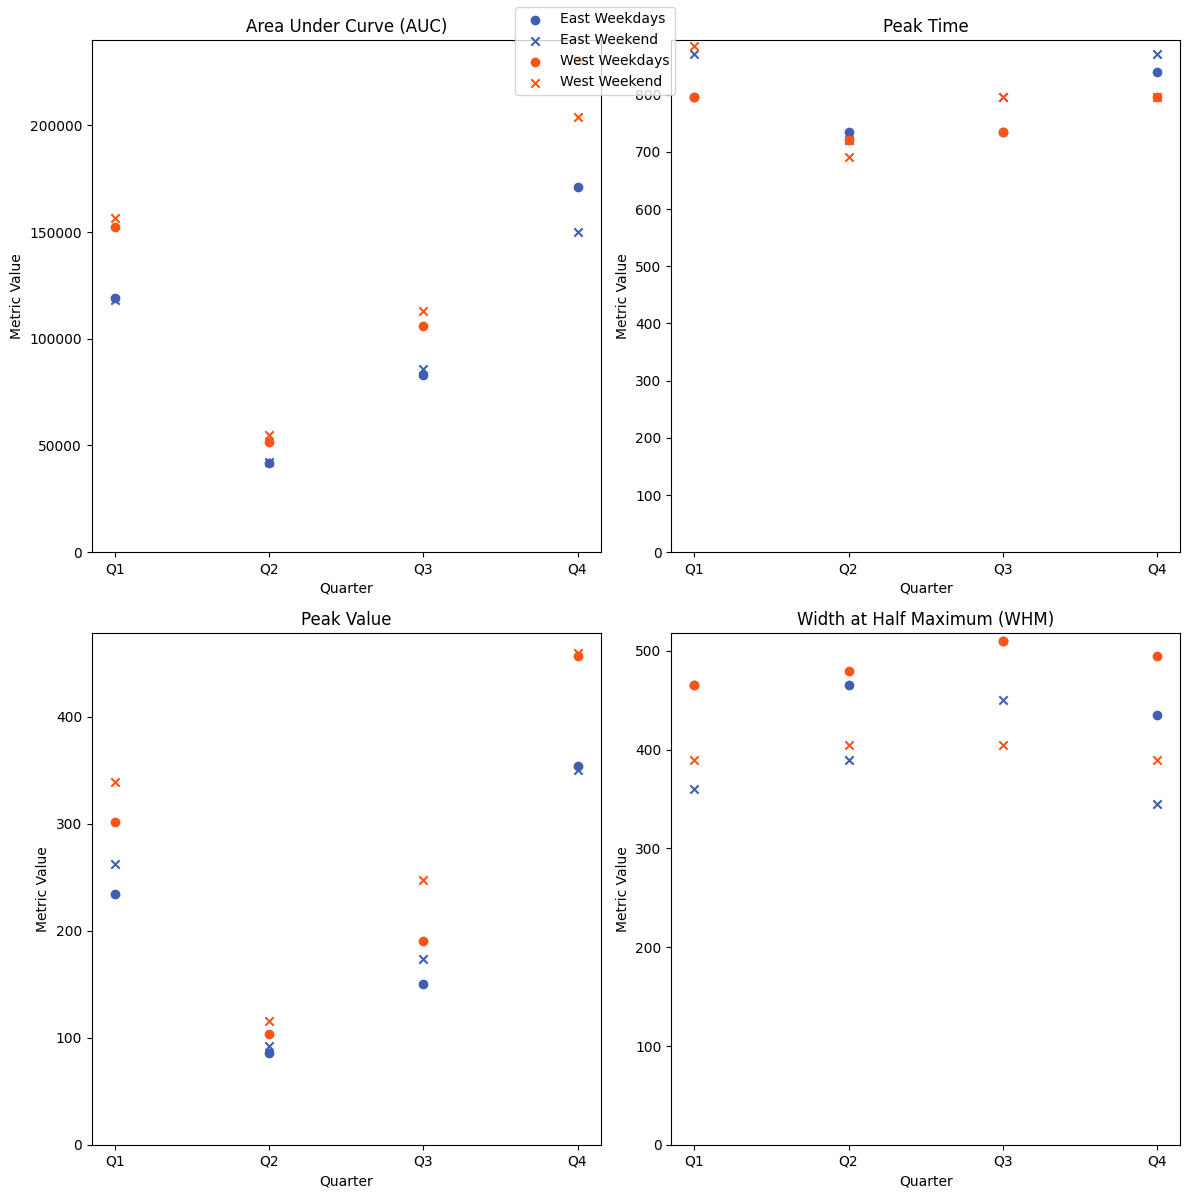

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# define your line scatters for east with color custom_palette[0] for blue
east_weekday_auc = ax[0, 0].scatter(
    east_weekday_metrics["quarter"],
    east_weekday_metrics["AUC"],
    label="East Weekdays",
    color=custom_palette[0],
)
east_weekend_auc = ax[0, 0].scatter(
    east_weekend_metrics["quarter"],
    east_weekend_metrics["AUC"],
    label="East Weekend",
    marker="x",
    color=custom_palette[0],
)

east_weekday_peak_time = ax[0, 1].scatter(
    east_weekday_metrics["quarter"],
    east_weekday_metrics["peak_time"],
    label="East Weekdays",
    color=custom_palette[0],
)
east_weekend_peak_time = ax[0, 1].scatter(
    east_weekend_metrics["quarter"],
    east_weekend_metrics["peak_time"],
    label="East Weekend",
    marker="x",
    color=custom_palette[0],
)

east_weekday_peak_value = ax[1, 0].scatter(
    east_weekday_metrics["quarter"],
    east_weekday_metrics["peak_value"],
    label="East Weekdays",
    color=custom_palette[0],
)
east_weekend_peak_value = ax[1, 0].scatter(
    east_weekend_metrics["quarter"],
    east_weekend_metrics["peak_value"],
    label="East Weekend",
    marker="x",
    color=custom_palette[0],
)

east_weekday_whm = ax[1, 1].scatter(
    east_weekday_metrics["quarter"],
    east_weekday_metrics["WHM"],
    label="East Weekdays",
    color=custom_palette[0],
)
east_weekend_whm = ax[1, 1].scatter(
    east_weekend_metrics["quarter"],
    east_weekend_metrics["WHM"],
    label="East Weekend",
    marker="x",
    color=custom_palette[0],
)

# define your line scatters for west with color custom_palette[1] for red
west_weekday_auc = ax[0, 0].scatter(
    west_weekday_metrics["quarter"],
    west_weekday_metrics["AUC"],
    label="West Weekdays",
    color=custom_palette[1],
)
west_weekend_auc = ax[0, 0].scatter(
    west_weekend_metrics["quarter"],
    west_weekend_metrics["AUC"],
    label="West Weekend",
    marker="x",
    color=custom_palette[1],
)

west_weekday_peak_time = ax[0, 1].scatter(
    west_weekday_metrics["quarter"],
    west_weekday_metrics["peak_time"],
    label="West Weekdays",
    color=custom_palette[1],
)
west_weekend_peak_time = ax[0, 1].scatter(
    west_weekend_metrics["quarter"],
    west_weekend_metrics["peak_time"],
    label="West Weekend",
    marker="x",
    color=custom_palette[1],
)

west_weekday_peak_value = ax[1, 0].scatter(
    west_weekday_metrics["quarter"],
    west_weekday_metrics["peak_value"],
    label="West Weekdays",
    color=custom_palette[1],
)
west_weekend_peak_value = ax[1, 0].scatter(
    west_weekend_metrics["quarter"],
    west_weekend_metrics["peak_value"],
    label="West Weekend",
    marker="x",
    color=custom_palette[1],
)

west_weekday_whm = ax[1, 1].scatter(
    west_weekday_metrics["quarter"],
    west_weekday_metrics["WHM"],
    label="West Weekdays",
    color=custom_palette[1],
)
west_weekend_whm = ax[1, 1].scatter(
    west_weekend_metrics["quarter"],
    west_weekend_metrics["WHM"],
    label="West Weekend",
    marker="x",
    color=custom_palette[1],
)

# the rest of the code remains unchanged

ax[0, 0].set_title("Area Under Curve (AUC)")
ax[0, 1].set_title("Peak Time")
ax[1, 0].set_title("Peak Value")
ax[1, 1].set_title("Width at Half Maximum (WHM)")

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Quarter")
        ax[i, j].set_ylabel("Metric Value")

for i in range(2):
    for j in range(2):
        ax[i, j].set_ylim(bottom=0)

# add a legend
fig.legend(
    [east_weekday_auc, east_weekend_auc, west_weekday_auc, west_weekend_auc],
    ["East Weekdays", "East Weekend", "West Weekdays", "West Weekend"],
    loc="upper center",
)

plt.tight_layout()
plt.show()

Rather looking at the Peak time and Peak time in isolation we should plot them with time of day on the x-axis and flow on the y-axis as above. This plot shows more clearly how peak values change relative to peak time throughout the year and for weekend/weekday. It is evident that the peak time is (for most of the year) 30-90 mins later at the weekend than during the weekdays. The exception is during Q2 where it is 15 mins earlier at the weekend than during the weekdays. It might be useful to investigate this pattern at greater granularity using months rather than quarters. 

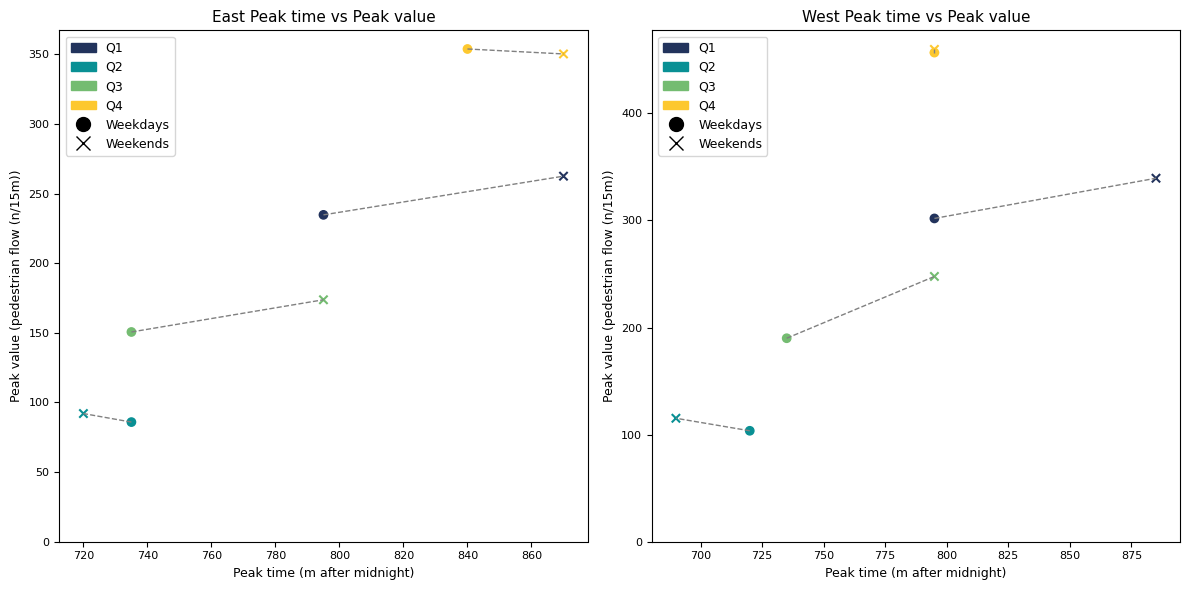

In [30]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

cmap = matplotlib.colors.ListedColormap([custom_colormap(i / 11) for i in range(12)])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for direction, metrics_weekday, metrics_weekend, index in zip(
    ["East", "West"],
    [east_weekday_metrics, west_weekday_metrics],
    [east_weekend_metrics, west_weekend_metrics],
    [0, 1],
):
    for i in range(4):  # Assume there are 12 months in your data
        # Plot a line between the weekday and weekend points for each month
        ax[index].plot(
            [metrics_weekday["peak_time"][i], metrics_weekend["peak_time"][i]],
            [metrics_weekday["peak_value"][i], metrics_weekend["peak_value"][i]],
            color="gray",
            linewidth=1,
            linestyle="--",
        )

    ax[index].scatter(
        metrics_weekday["peak_time"],
        metrics_weekday["peak_value"],
        c=metrics_weekday.index,
        cmap=cmap,
        marker="o",
    )
    ax[index].scatter(
        metrics_weekend["peak_time"],
        metrics_weekend["peak_value"],
        c=metrics_weekend.index,
        cmap=cmap,
        marker="x",
    )
    ax[index].set_ylim(0)
    ax[index].set_xlabel("Peak time (m after midnight)", fontsize=9)
    ax[index].set_ylabel("Peak value (pedestrian flow (n/15m))", fontsize=9)
    ax[index].tick_params(labelsize=8)

    # create a legend for quarters
    quarter_handles = [
        mpatches.Patch(color=cmap(i / 3), label=f"Q{i+1}") for i in range(4)
    ]

    # create a legend for weekdays and weekends
    weekday_line = mlines.Line2D(
        [],
        [],
        color="black",
        marker="o",
        linestyle="None",
        markersize=10,
        label="Weekdays",
    )
    weekend_line = mlines.Line2D(
        [],
        [],
        color="black",
        marker="x",
        linestyle="None",
        markersize=10,
        label="Weekends",
    )

    ax[index].legend(
        handles=quarter_handles + [weekday_line, weekend_line],
        loc="upper left",
        fontsize=9,
    )

    ax[index].set_title(f"{direction} Peak time vs Peak value", fontsize=11)

plt.tight_layout()
plt.show()

(2.3.3.2)=
#### 2.3.3.2 Pattern properties of monthly mean trendlines

In [31]:
from scipy import integrate

# initialize list to store metrics DataFrames for weekends and weekdays
east_weekend_metrics = []
east_weekday_metrics = []
west_weekend_metrics = []
west_weekday_metrics = []

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

# For East
east_month_interval_mean_df = (
    weekend_east_df.groupby(["month", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each month and add to DataFrame for weekends
for month in range(1, 13):
    month_data = east_month_interval_mean_df[
        east_month_interval_mean_df["month"] == month
    ]
    auc = integrate.trapz(month_data["value"], dx=15)  # dx time interval is 15 minutes
    peak_time = month_data["minutes_since_midnight"][month_data["value"].idxmax()]
    peak_value = month_data["value"].max()
    whm_time_range = month_data["minutes_since_midnight"][
        (month_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    east_weekend_metrics.append(
        pd.DataFrame(
            {
                "month": [f"{month_names[month-1]}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# similarly, for weekdays
east_month_interval_mean_df = (
    weekday_east_df.groupby(["month", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each month and add to DataFrame for weekdays
for month in range(1, 13):
    month_data = east_month_interval_mean_df[
        east_month_interval_mean_df["month"] == month
    ]
    auc = integrate.trapz(month_data["value"], dx=15)  # dx time interval is 15 minutes
    peak_time = month_data["minutes_since_midnight"][month_data["value"].idxmax()]
    peak_value = month_data["value"].max()
    whm_time_range = month_data["minutes_since_midnight"][
        (month_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    east_weekday_metrics.append(
        pd.DataFrame(
            {
                "month": [f"{month_names[month-1]}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# For West
west_month_interval_mean_df = (
    weekend_west_df.groupby(["month", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each month and add to DataFrame for weekends
for month in range(1, 13):
    month_data = west_month_interval_mean_df[
        west_month_interval_mean_df["month"] == month
    ]
    auc = integrate.trapz(month_data["value"], dx=15)  # dx time interval is 15 minutes
    peak_time = month_data["minutes_since_midnight"][month_data["value"].idxmax()]
    peak_value = month_data["value"].max()
    whm_time_range = month_data["minutes_since_midnight"][
        (month_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    west_weekend_metrics.append(
        pd.DataFrame(
            {
                "month": [f"{month_names[month-1]}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# similarly, for weekdays
west_month_interval_mean_df = (
    weekday_west_df.groupby(["month", "minutes_since_midnight"])["value"]
    .mean()
    .reset_index()
)

# compute metrics for each month and add to DataFrame for weekdays
for month in range(1, 13):
    month_data = west_month_interval_mean_df[
        west_month_interval_mean_df["month"] == month
    ]
    auc = integrate.trapz(month_data["value"], dx=15)  # dx time interval is 15 minutes
    peak_time = month_data["minutes_since_midnight"][month_data["value"].idxmax()]
    peak_value = month_data["value"].max()
    whm_time_range = month_data["minutes_since_midnight"][
        (month_data["value"] >= peak_value / 2)
    ]
    whm = (
        whm_time_range.max() - whm_time_range.min()
    )  # calculate WHM as (minutes_since_midnight is a numeric value)
    west_weekday_metrics.append(
        pd.DataFrame(
            {
                "month": [f"{month_names[month-1]}"],
                "AUC": [auc],
                "peak_time": [peak_time],
                "peak_value": [peak_value],
                "WHM": [whm],
            }
        )
    )

# concatenate the list of dataframes to a single dataframe
east_weekend_metrics = pd.concat(east_weekend_metrics, ignore_index=True)
east_weekday_metrics = pd.concat(east_weekday_metrics, ignore_index=True)

west_weekend_metrics = pd.concat(west_weekend_metrics, ignore_index=True)
west_weekday_metrics = pd.concat(west_weekday_metrics, ignore_index=True)

# Compute the deltas
east_weekend_metrics["delta_peak_time"] = (
    east_weekend_metrics["peak_time"] - east_weekday_metrics["peak_time"]
)
east_weekend_metrics["delta_peak_value"] = (
    east_weekend_metrics["peak_value"] - east_weekday_metrics["peak_value"]
)

east_weekday_metrics["delta_peak_time"] = (
    east_weekday_metrics["peak_time"] - east_weekend_metrics["peak_time"]
)
east_weekday_metrics["delta_peak_value"] = (
    east_weekday_metrics["peak_value"] - east_weekend_metrics["peak_value"]
)

west_weekend_metrics["delta_peak_time"] = (
    west_weekend_metrics["peak_time"] - west_weekday_metrics["peak_time"]
)
west_weekend_metrics["delta_peak_value"] = (
    west_weekend_metrics["peak_value"] - west_weekday_metrics["peak_value"]
)

west_weekday_metrics["delta_peak_time"] = (
    west_weekday_metrics["peak_time"] - west_weekend_metrics["peak_time"]
)
west_weekday_metrics["delta_peak_value"] = (
    west_weekday_metrics["peak_value"] - west_weekend_metrics["peak_value"]
)

Unsurprisingly the pattern becomes slightly more chaotic as we go more granular. However, the U shape of AUC and Peak value still largely holds and there is still a consistent seperation between weekends and weekdays for WHM. Let's have a look at peak time and peak value on the same plot again. 

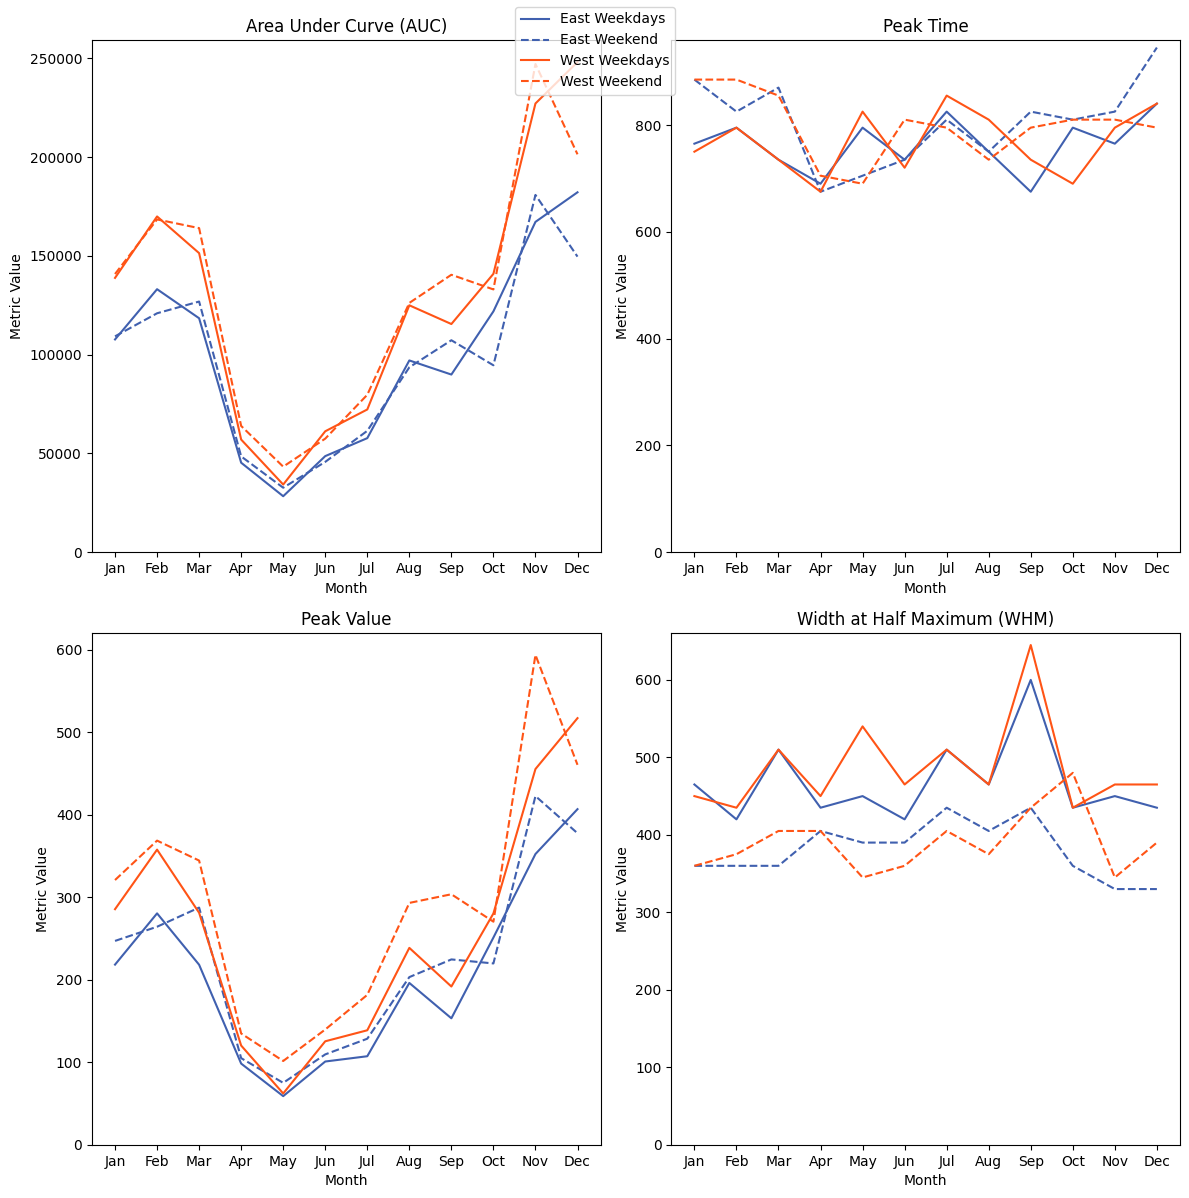

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# define your line plots for east with color custom_palette[0] for blue
(east_weekday_auc,) = ax[0, 0].plot(
    east_weekday_metrics["month"],
    east_weekday_metrics["AUC"],
    label="East Weekdays",
    color=custom_palette[0],
)
(east_weekend_auc,) = ax[0, 0].plot(
    east_weekend_metrics["month"],
    east_weekend_metrics["AUC"],
    label="East Weekend",
    linestyle="--",
    color=custom_palette[0],
)

(east_weekday_peak_time,) = ax[0, 1].plot(
    east_weekday_metrics["month"],
    east_weekday_metrics["peak_time"],
    label="East Weekdays",
    color=custom_palette[0],
)
(east_weekend_peak_time,) = ax[0, 1].plot(
    east_weekend_metrics["month"],
    east_weekend_metrics["peak_time"],
    label="East Weekend",
    linestyle="--",
    color=custom_palette[0],
)

(east_weekday_peak_value,) = ax[1, 0].plot(
    east_weekday_metrics["month"],
    east_weekday_metrics["peak_value"],
    label="East Weekdays",
    color=custom_palette[0],
)
(east_weekend_peak_value,) = ax[1, 0].plot(
    east_weekend_metrics["month"],
    east_weekend_metrics["peak_value"],
    label="East Weekend",
    linestyle="--",
    color=custom_palette[0],
)

(east_weekday_whm,) = ax[1, 1].plot(
    east_weekday_metrics["month"],
    east_weekday_metrics["WHM"],
    label="East Weekdays",
    color=custom_palette[0],
)
(east_weekend_whm,) = ax[1, 1].plot(
    east_weekend_metrics["month"],
    east_weekend_metrics["WHM"],
    label="East Weekend",
    linestyle="--",
    color=custom_palette[0],
)

# define your line plots for west with color custom_palette[1] for red
(west_weekday_auc,) = ax[0, 0].plot(
    west_weekday_metrics["month"],
    west_weekday_metrics["AUC"],
    label="West Weekdays",
    color=custom_palette[1],
)
(west_weekend_auc,) = ax[0, 0].plot(
    west_weekend_metrics["month"],
    west_weekend_metrics["AUC"],
    label="West Weekend",
    linestyle="--",
    color=custom_palette[1],
)

(west_weekday_peak_time,) = ax[0, 1].plot(
    west_weekday_metrics["month"],
    west_weekday_metrics["peak_time"],
    label="West Weekdays",
    color=custom_palette[1],
)
(west_weekend_peak_time,) = ax[0, 1].plot(
    west_weekend_metrics["month"],
    west_weekend_metrics["peak_time"],
    label="West Weekend",
    linestyle="--",
    color=custom_palette[1],
)

(west_weekday_peak_value,) = ax[1, 0].plot(
    west_weekday_metrics["month"],
    west_weekday_metrics["peak_value"],
    label="West Weekdays",
    color=custom_palette[1],
)
(west_weekend_peak_value,) = ax[1, 0].plot(
    west_weekend_metrics["month"],
    west_weekend_metrics["peak_value"],
    label="West Weekend",
    linestyle="--",
    color=custom_palette[1],
)

(west_weekday_whm,) = ax[1, 1].plot(
    west_weekday_metrics["month"],
    west_weekday_metrics["WHM"],
    label="West Weekdays",
    color=custom_palette[1],
)
(west_weekend_whm,) = ax[1, 1].plot(
    west_weekend_metrics["month"],
    west_weekend_metrics["WHM"],
    label="West Weekend",
    linestyle="--",
    color=custom_palette[1],
)

# the rest of the code remains unchanged

ax[0, 0].set_title("Area Under Curve (AUC)")
ax[0, 1].set_title("Peak Time")
ax[1, 0].set_title("Peak Value")
ax[1, 1].set_title("Width at Half Maximum (WHM)")

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("Month")
        ax[i, j].set_ylabel("Metric Value")

for i in range(2):
    for j in range(2):
        ax[i, j].set_ylim(bottom=0)

# add a legend
fig.legend(
    [east_weekday_auc, east_weekend_auc, west_weekday_auc, west_weekend_auc],
    ["East Weekdays", "East Weekend", "West Weekdays", "West Weekend"],
    loc="upper center",
)

plt.tight_layout()
plt.show()

Again the pattern appears more chaotic but the general trend still holds. To make this easier to interpret lets plot the deltas between weekend and weekday rather than the actual values. 

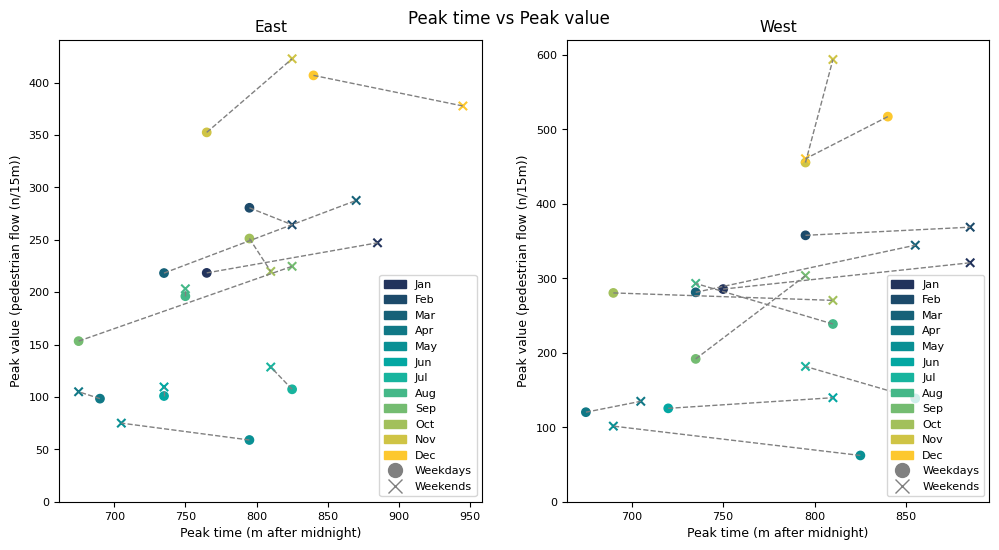

In [33]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

cmap = matplotlib.colors.ListedColormap([custom_colormap(i / 11) for i in range(12)])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# For East
for i in range(12):  # for the 12 months
    # plot a line between the weekday and weekend points for each month
    ax[0].plot(
        [east_weekday_metrics["peak_time"][i], east_weekend_metrics["peak_time"][i]],
        [east_weekday_metrics["peak_value"][i], east_weekend_metrics["peak_value"][i]],
        color="gray",
        linewidth=1,
        linestyle="--",
    )

# plot the data
ax[0].scatter(
    east_weekday_metrics["peak_time"],
    east_weekday_metrics["peak_value"],
    c=east_weekday_metrics.index,
    cmap=cmap,
    marker="o",
)
ax[0].scatter(
    east_weekend_metrics["peak_time"],
    east_weekend_metrics["peak_value"],
    c=east_weekend_metrics.index,
    cmap=cmap,
    marker="x",
)
ax[0].set_ylim(0)
ax[0].set_xlabel("Peak time (m after midnight)", fontsize=9)
ax[0].set_ylabel("Peak value (pedestrian flow (n/15m))", fontsize=9)
ax[0].tick_params(labelsize=8)
ax[0].set_title("East", fontsize=11)

# For West
for i in range(12):  # for the 12 months
    # plot a line between the weekday and weekend points for each month
    ax[1].plot(
        [west_weekday_metrics["peak_time"][i], west_weekend_metrics["peak_time"][i]],
        [west_weekday_metrics["peak_value"][i], west_weekend_metrics["peak_value"][i]],
        color="gray",
        linewidth=1,
        linestyle="--",
    )

# plot the data
ax[1].scatter(
    west_weekday_metrics["peak_time"],
    west_weekday_metrics["peak_value"],
    c=west_weekday_metrics.index,
    cmap=cmap,
    marker="o",
)
ax[1].scatter(
    west_weekend_metrics["peak_time"],
    west_weekend_metrics["peak_value"],
    c=west_weekend_metrics.index,
    cmap=cmap,
    marker="x",
)
ax[1].set_ylim(0)
ax[1].set_xlabel("Peak time (m after midnight)", fontsize=9)
ax[1].set_ylabel("Peak value (pedestrian flow (n/15m))", fontsize=9)
ax[1].tick_params(labelsize=8)
ax[1].set_title("West", fontsize=11)

# create a legend for months
month_handles = [
    mpatches.Patch(color=cmap(i / 11), label=f"{month_names[i]}") for i in range(12)
]

# create weekend/weekdays markers for the legend
weekday_marker = mlines.Line2D(
    [], [], color="gray", marker="o", linestyle="None", markersize=10, label="Weekdays"
)
weekend_marker = mlines.Line2D(
    [], [], color="gray", marker="x", linestyle="None", markersize=10, label="Weekends"
)

# add the legend for both the months and the weekday/weekend markers
ax[0].legend(
    handles=month_handles + [weekday_marker, weekend_marker],
    loc="lower right",
    fontsize=8,
)
ax[1].legend(
    handles=month_handles + [weekday_marker, weekend_marker],
    loc="lower right",
    fontsize=8,
)
plt.suptitle("Peak time vs Peak value", y=0.93)
plt.show()

If we plot these as the deltas between weekdays mean and weekends mean, we can attempt to group them according to quadrant location. 

It looks like there are two patterns that hold for both sensors. They are:
* February, October, December in the $(-x, y)$ quadrant.
* January, March, August, November in the $(-x, -y)$ quadrant.

This pattern possibly emerges form the combined influence of the Premier League season from August to May and the Newcastle and Northumbria Universities term dates.

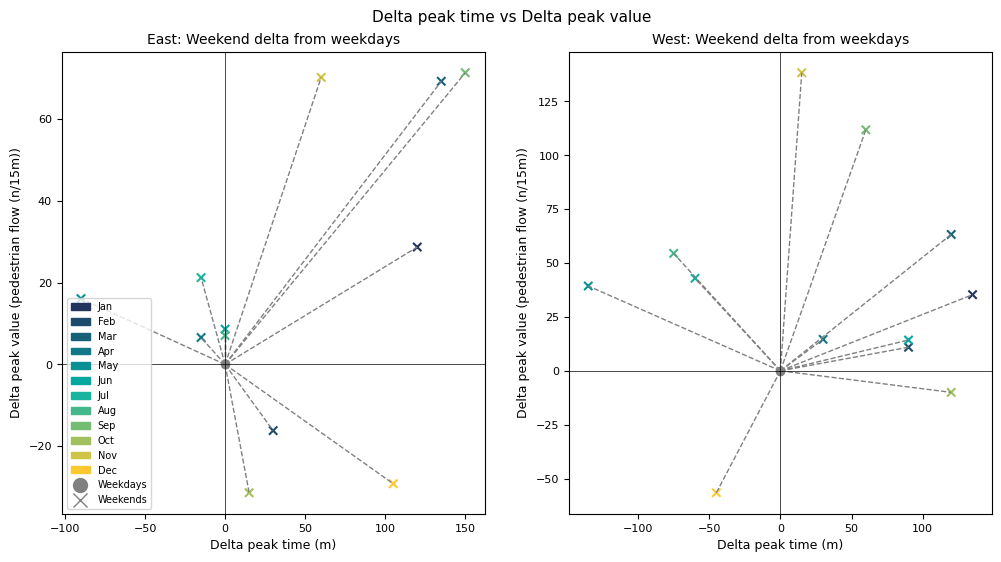

In [34]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

cmap = matplotlib.colors.ListedColormap([custom_colormap(i / 11) for i in range(12)])

fig, ax = plt.subplots(
    1, 2, figsize=(12, 6)
)  # Change to 12,12 to accommodate the additional subplots

# Create a legend for months
month_handles = [
    mpatches.Patch(color=cmap(i / 11), label=f"{month_names[i]}") for i in range(12)
]

# Create a legend for weekends
weekday_line = mlines.Line2D(
    [], [], color="gray", marker="o", linestyle="None", markersize=10, label="Weekdays"
)
weekend_line = mlines.Line2D(
    [], [], color="gray", marker="x", linestyle="None", markersize=10, label="Weekends"
)

# East: Plot the deltas and the lines from the origin for weekends
for i in range(12):
    ax[0].plot(
        [0, east_weekend_metrics["delta_peak_time"][i]],
        [0, east_weekend_metrics["delta_peak_value"][i]],
        color="gray",
        linewidth=1,
        linestyle="--",
    )

ax[0].scatter(
    east_weekend_metrics["delta_peak_time"],
    east_weekend_metrics["delta_peak_value"],
    c=east_weekend_metrics.index,
    cmap=cmap,
    marker="x",
)
ax[0].scatter(0, 0, c="gray", marker="o")
ax[0].axhline(0, color="black", linewidth=0.5)
ax[0].axvline(0, color="black", linewidth=0.5)
ax[0].set_xlabel("Delta peak time (m)", fontsize=9)
ax[0].set_ylabel("Delta peak value (pedestrian flow (n/15m))", fontsize=9)
ax[0].tick_params(labelsize=8)
ax[0].set_title("East: Weekend delta from weekdays", fontsize=10)

ax[0].legend(
    handles=month_handles + [weekday_line, weekend_line], loc="lower left", fontsize=7
)

# West: Plot the deltas and the lines from the origin for weekends
for i in range(12):
    ax[1].plot(
        [0, west_weekend_metrics["delta_peak_time"][i]],
        [0, west_weekend_metrics["delta_peak_value"][i]],
        color="gray",
        linewidth=1,
        linestyle="--",
    )

ax[1].scatter(
    west_weekend_metrics["delta_peak_time"],
    west_weekend_metrics["delta_peak_value"],
    c=west_weekend_metrics.index,
    cmap=cmap,
    marker="x",
)
ax[1].scatter(0, 0, c="gray", marker="o")
ax[1].axhline(0, color="black", linewidth=0.5)
ax[1].axvline(0, color="black", linewidth=0.5)
ax[1].set_xlabel("Delta peak time (m)", fontsize=9)
ax[1].set_ylabel("Delta peak value (pedestrian flow (n/15m))", fontsize=9)
ax[1].tick_params(labelsize=8)
ax[1].set_title("West: Weekend delta from weekdays", fontsize=10)

plt.suptitle("Delta peak time vs Delta peak value", fontsize=11, y=0.95)
plt.show()

Lets check if any of these values hold statistical significance.

WIP (I can't figure out how to do this bit just yet).

(2.3.4)=
### 2.3.4 Signal decomposition

The Fourier Transform is a mathematical technique used in signal processing and image analysis, among many other fields. Named after the French mathematician and physicist Jean-Baptiste Joseph Fourier, it is a way of breaking down a complex signal into a set of simple sine waves of different frequencies. This breakdown is useful because it allows us to analyze the signal in the frequency domain, which can reveal important features that are not readily apparent in the time domain {cite}`bloomfield2004fourier`.

The Fourier Transform for a function $f(t)$ is defined as:
$$
F(\omega) = \int_{-\infty}^{\infty} f(t)e^{-i\omega t} dt
$$

The Discrete Fourier Transform (DFT) is a version of the Fourier Transform that is suitable for sequences of numbers like a time-series. Like the Fourier Transform, it transforms a signal from the time domain into the frequency domain, but it does this for a finite set of data points rather than a continuous function. The DFT is implemented in practice using the Fast Fourier Transform (FFT) algorithm, which significantly reduces computational time {cite}`oppenheim1999discrete`.

The Discrete Fourier Transform (DFT) for a sequence of $N$ complex numbers $x_0, x_1, ..., x_{N-1}$ is:
$$
X_k = \sum_{n=0}^{N-1} x_n e^{-\frac{i 2 \pi}{N} kn}
$$

The Fourier Transform transform is particularly useful in time series analysis for a couple of reasons {cite}`bracewell1986fourier`:

1. **Identification of periodicity**: Fourier Transform can be used to identify cyclical patterns or seasonality by decomposing the time series into its frequency components. Peaks in the frequency domain represent the frequencies at which the data is oscillating.

2. **Filtering and noise reduction**: By transforming the time series data into the frequency domain, it's possible to identify and filter out high-frequency noise, making it easier to identify underlying patterns in the data.


However, one limitation of traditional Fourier methods is that they assume the data is stationary - i.e., its properties do not change over time. This is almost certainly not the case with our data and we can expect to see trends or changes in variance over time. As a result, variations of the Fourier Transform that can handle non-stationary data, such as the Short-Time Fourier Transform or Wavelet Transform, may be more appropriate in this case {cite}`jones1989resolution`. 
The Short-Time Fourier Transform (STFT) of a signal $x(t)$ with a chosen window function $w(t)$ is given by:

$$
STFT\{x(t)\}(\tau, \omega) = \int_{-\infty}^{\infty} x(t)w(t-\tau)e^{-i\omega t} dt
$$

The final caveat on for FFT's is that our data is incomplete (see section 2.4) with missing periods of significanlty different length (some gaps are several weeks). All the Fourier Transforms listed above require equispaced data. For now, we want to avoid any data imputation or interpolation as this might introduce artificial patterns. The Non-equispaced Fast Fourier Transform (NFFT) offers one solution to this problem and exists as a Python library called `pyNFFT`. However it is rather difficult to install on Windows operating systems. This is something that can be attempted later on in the research. 

The Lomb-Scargle Periodogram (LSP) is a Fourier method which is implemented in the `scipy` library and computes a Fourier-like power spectrum estimator. LSP involves fitting a model to the data at each candidate frequency and selecting the frequency that maximizes the likelihood, which makes it more flexible and suitable for data that doesn't align neatly with whole cycles of sine waves. One of the key assumptions made by the Periodogram is that the noise is Gaussian and evenly distributed {cite}`vanderplas2018understanding`.

We can see from the LSP that the most powerful signals arise at 12 and 24 hour period. This makes sense as we expect the daily routine would dominate. We would expect the most powerful signals to arise in 24 hours cycles i.e. people generally carry out the same patterns of activity at the same hours of each day. The 12 hour frequency is slightly less easy to explain. It most likely arises from standards daily routines like going to work and returning home.

In [35]:
sorted_east_df = east_df.sort_values("dt").reset_index()
sorted_west_df = west_df.sort_values("dt").reset_index()

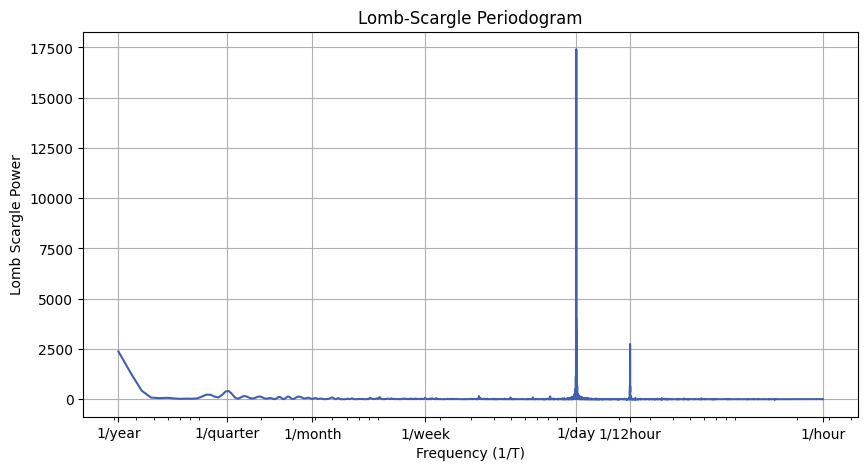

In [36]:
import numpy as np
from scipy.signal import lombscargle
import matplotlib.pyplot as plt
import pandas as pd

# suppose `times` and `observations` are your data
times = np.array((sorted_east_df["dt"] - sorted_east_df["dt"][0]).dt.total_seconds())
observations = np.array(sorted_east_df["value"], dtype=float)

# normalize the input time-series data
mean = np.mean(observations)
observations -= mean
variance = np.var(observations)
observations /= np.sqrt(variance)

# define periods of interest (in seconds)
T_hour = 60 * 60
T_day = 24 * T_hour
T_week = 7 * T_day
T_month = 30 * T_day  # approximate
T_quarter = 3 * T_month
T_year = 365 * T_day

# convert periods to angular frequencies and create frequency array
freq_hour = 2 * np.pi / T_hour
freq_day = 2 * np.pi / T_day
freq_week = 2 * np.pi / T_week
freq_month = 2 * np.pi / T_month
freq_quarter = 2 * np.pi / T_quarter
freq_year = 2 * np.pi / T_year

frequencies = np.linspace(freq_year, freq_hour, num=50000)

# compute the Lomb-Scargle periodogram of the normalized data
periodogram = lombscargle(times, observations, frequencies)

# convert angular frequencies to regular frequencies for plotting
frequencies = frequencies / (2.0 * np.pi)

# plot the periodogram with a log-scaled x-axis
plt.figure(figsize=(10, 5))
plt.plot(frequencies, periodogram)
plt.xscale("log")
plt.gca().set_xticks(
    [
        1 / T_year,
        1 / T_quarter,
        1 / T_month,
        1 / T_week,
        1 / (T_day),
        1 / (12 * T_hour),
        1 / (T_hour),
    ]
)
plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())
plt.gca().set_xticklabels(
    ["1/year", "1/quarter", "1/month", "1/week", "1/day", "1/12hour", "1/hour"]
)
plt.xlabel("Frequency (1/T)")
plt.ylabel("Lomb Scargle Power")
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.show()

If we set the frequency range to 1/year and 1/week we can see more clearly the respective power of the lower frequencies. The next most powerful frequencies arise over quarterly and yearly periods. Again, we expect a reasonably strong annual signal as this means people carry out similar patterns of activity at similar points each year. Quarters are more tricky to explain, a possible reason might include the school/university holiday schedules which generally follow a quarterly cycle. 

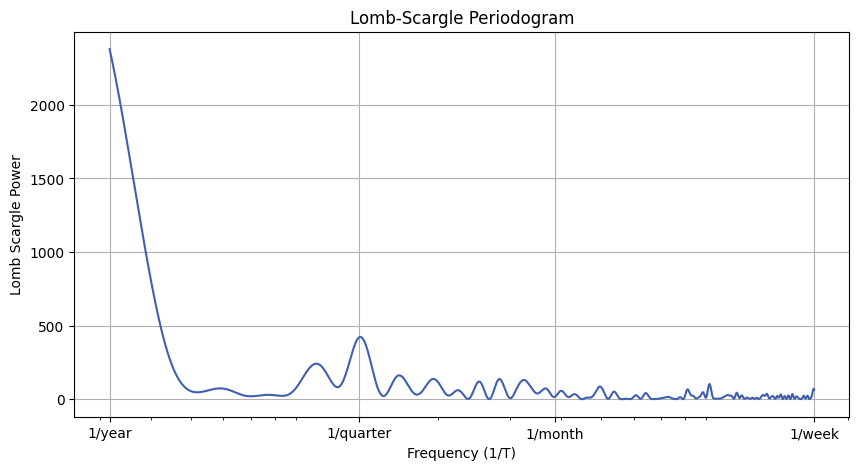

In [37]:
# zoom in on year to week frequency range

frequencies = np.linspace(freq_year, freq_week, num=10000)

# compute the Lomb-Scargle periodogram of the normalized data
periodogram = lombscargle(times, observations, frequencies)

# convert angular frequencies to regular frequencies for plotting
frequencies = frequencies / (2.0 * np.pi)

# plot the periodogram with a log-scaled x-axis
plt.figure(figsize=(10, 5))
plt.plot(frequencies, periodogram)
plt.xscale("log")
plt.gca().set_xticks([1 / T_year, 1 / T_quarter, 1 / T_month, 1 / T_week])
plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())
plt.gca().set_xticklabels(["1/year", "1/quarter", "1/month", "1/week"])
plt.xlabel("Frequency (1/T)")
plt.ylabel("Lomb Scargle Power")
plt.title("Lomb-Scargle Periodogram")
plt.grid(True)
plt.show()

In [38]:
east_df["dt"].min()
east_df["dt"].max()

Timestamp('2023-03-31 23:45:00')

## References

```{bibliography}
:filter: docname in docnames
```